# Traffic sign recognition

### Setup

In [ ]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [ ]:
root_dir = "drive/My Drive/"
base_dir = root_dir + 'Colab Notebooks/traffic-sign-recognition/'

In [ ]:
from fastai.vision import *
from fastai.metrics import error_rate

In [ ]:
data_dir = 'data/traffic-sign-data'

def model_safe_path(name):
  return '/models/'+name+'.pth'

def save_learn_model(name):
  shutil.copyfile(data_dir + model_safe_path(name), base_dir + model_safe_path(name))

def load_learn_model(name):
  shutil.copyfile(base_dir + model_safe_path(name), data_dir + model_safe_path(name))

### Loading the data

Copy and unzip learning data

In [ ]:
import shutil
import zipfile

shutil.copyfile(base_dir+'traffic-sign-data.zip', 'data/traffic-sign-data.zip')
with zipfile.ZipFile('data/traffic-sign-data.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

In [ ]:
import pandas as pd

df = pd.read_csv('data/traffic-sign-data/Train.csv')
df = df.iloc[:,6:]
df = df.rename(columns={'ClassId':'label', 'Path':'name'})
df = df.reindex(columns=['name', 'label'])
df.head()

,name,label
0,Train/20/00020_00000_00000.png,20
1,Train/20/00020_00000_00001.png,20
2,Train/20/00020_00000_00002.png,20
3,Train/20/00020_00000_00003.png,20
4,Train/20/00020_00000_00004.png,20


In [ ]:
path = Path('data/traffic-sign-data')
data = ImageDataBunch.from_df(path, df, ds_tfms=get_transforms(), size=224).normalize(imagenet_stats)

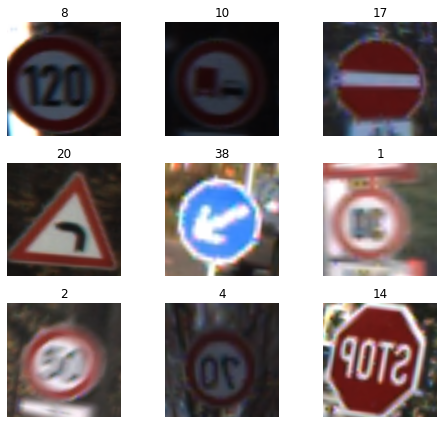

In [ ]:
data.show_batch(rows=3, figsize=(7,6))

### Teaching the model

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


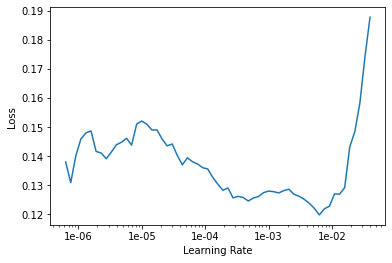

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.769545,0.365458,0.128172,04:13
1,0.298326,0.142878,0.048973,04:32
2,0.176511,0.079691,0.027420,04:18
3,0.138023,0.061762,0.020788,04:15


In [ ]:
learn.save('stage-1')

### Fine tuning

In [ ]:
learn.load('stage-1')

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(3e-5, 3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.072857,0.024556,0.008927,04:29
1,0.022626,0.007880,0.003061,04:30


In [ ]:
learn.save('stage-2')

### Look at the results

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

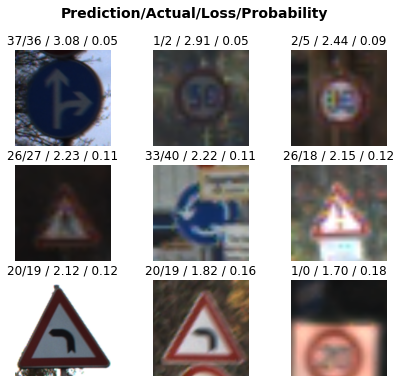

In [ ]:
interp.plot_top_losses(9, figsize=(7, 6))

### Tuning without image flipping

In [ ]:
data_no_flip = ImageDataBunch.from_df(path, df, ds_tfms=get_transforms(do_flip=False), size=224).normalize(imagenet_stats)

In [ ]:
learn.freeze()

In [ ]:
learn.data = data_no_flip

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


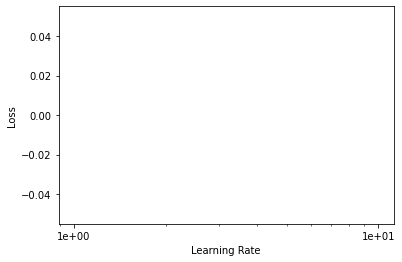

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,error_rate,time
0,0.021825,0.004905,0.002168,04:15
1,0.012047,0.003272,0.001403,04:07


In [ ]:
learn.save('stage-3')

### Trying to eliminate underfitting

In [ ]:
learn.load('stage-3')

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


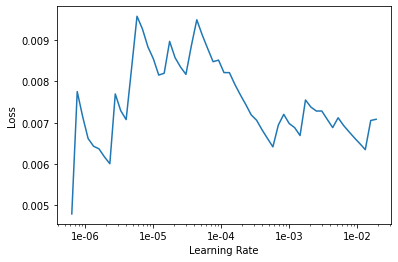

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(4, max_lr=slice(1e-4,3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.009671,0.000907,0.000255,05:38
1,0.010299,0.000773,0.000255,05:42
2,0.004948,0.000756,0.000128,05:33
3,0.006333,0.000727,0.000128,05:39


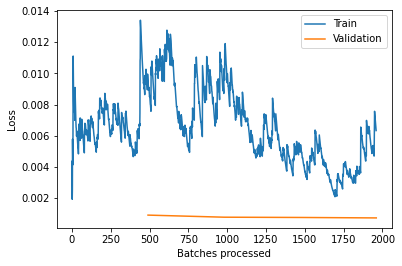

In [ ]:
learn.recorder.plot_losses()

Learning rate might be a bit too high, but it also might be that we are just too close to perfection.

In [ ]:
learn.save('stage-4')

In [ ]:
save_learn_model('stage-4')

### Results

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

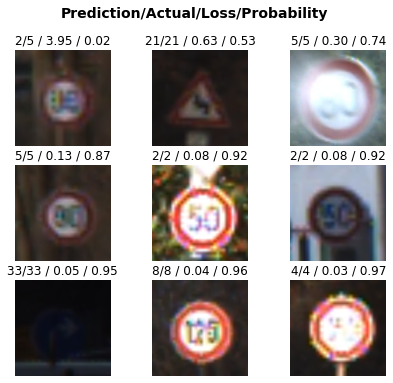

In [ ]:
interp.plot_top_losses(9, figsize=(7, 6))

Final accuracy achieved: **99.9872%**

### Test

In [ ]:
import pandas as pd

ROOT_DIR = 'data/traffic-sign-data'

def saver(row):
  label = row['ClassId']
  path = row['Path']

  save_dir = ROOT_DIR + '/test/' + str(label)
  if not os.path.isdir(save_dir):
    os.mkdir(save_dir)
  save_to = save_dir + '/' + path[5:]

  shutil.copyfile(ROOT_DIR + '/' + path, save_to)

In [ ]:
os.mkdir('data/traffic-sign-data/test')

In [ ]:
df = pd.read_csv(ROOT_DIR + '/Test.csv')
df.apply(saver, axis=1)

In [ ]:
data_test = ImageDataBunch.from_folder('data/traffic-sign-data', train='Train', valid='test', size=224)

In [ ]:
test_learn = cnn_learner(data_test, models.resnet34, metrics=accuracy)

In [ ]:
import os

os.mkdir(ROOT_DIR + '/models')
load_learn_model('stage-4')

In [ ]:
test_learn.load('stage-4')

In [ ]:
preds, y = test_learn.get_preds(ds_type=DatasetType.Valid)
preds, y

(tensor([[3.3822e-06, 9.3650e-05, 3.8501e-05,  ..., 1.2439e-05, 4.3615e-05,
          3.6280e-06],
         [3.8837e-04, 2.1914e-06, 5.5451e-06,  ..., 2.4258e-06, 6.6244e-06,
          4.9992e-06],
         [4.5599e-05, 1.7120e-06, 1.3793e-05,  ..., 2.7886e-06, 1.6425e-06,
          3.5866e-07],
         ...,
         [8.0745e-08, 9.9759e-07, 9.9999e-01,  ..., 1.8028e-08, 8.8853e-10,
          8.7226e-10],
         [2.8389e-09, 8.2781e-10, 1.0000e+00,  ..., 1.3682e-08, 9.6286e-10,
          4.8131e-10],
         [1.3197e-06, 2.1366e-05, 9.6284e-01,  ..., 2.6382e-06, 1.6233e-08,
          1.2257e-08]]), tensor([24, 24, 24,  ..., 12, 12, 12]))

In [ ]:
new_y = torch.argmax(preds, dim=1)

In [ ]:
new_y

tensor([17, 30, 30,  ...,  2,  2,  2])

In [ ]:
prediction = test_learn.predict(data_test.valid_ds.x[1])
prediction[0]

Category tensor(30)

In [ ]:
data_test.valid_ds.y[2]

Category 24

In [ ]:
res = test_learn.validate()

In [ ]:
res

[16.58951, tensor(0.0617)]